<a href="https://colab.research.google.com/github/Nicordaro/Homework3_PACS/blob/master/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
def loss_plot(losses, steps):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep([steps,losses],s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 1000 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(20,19), facecolor='white')

  plt.rc('font', size=20)
  plt.plot(steps,losses,'.' , xnew ,ynew, label = "accuracy", c='red' )
  ax.set_ylabel("Loss")
  ax.set_xlabel("Steps")
  ax.minorticks_on()
  plt.title("Loss trend")
  plt.yticks(np.arange(0, max(losses)+.1, .1))
  plt.xticks(np.arange(0, len(steps)*10, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip(steps, losses):  # Plot also the value of the point close to it
    if (in_i)%30 ==0 or in_i ==0 or in_i==170:
      ax.annotate(str(round(in_j, 5)), xy=(in_i, in_j), xytext=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

**Import libraries**

In [0]:
import os
import copy
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.hub import load_state_dict_from_url
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt


import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7      # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR =  1e-3           # The initial Learning Rate
LR_DANN = 1e-3
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])

**Prepare Dataset**

In [5]:
# Clone github repository with data
if not os.path.isdir('./Homework3_PACS'):
  !git clone https://github.com/Nicordaro/Homework3_PACS
from Homework3_PACS.DANN import dann
DATA_DIR = 'Homework3_PACS/PACS'

# Read folder for each domain
Arts = ImageFolder(DATA_DIR+"/art_painting", transform=eval_transform)
Cartoons = ImageFolder(DATA_DIR+"/cartoon", transform=train_transform) 
Photos = ImageFolder(DATA_DIR+"/photo", transform=train_transform) 
Sketches = ImageFolder(DATA_DIR+"/sketch", transform=train_transform)

Cloning into 'Homework3_PACS'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10039 (delta 1), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10039/10039), 174.13 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (9994/9994), done.


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(Arts, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(Arts, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [5]:
alexnet = torchvision.models.alexnet(pretrained = True)
dann_net = dann(pretrained = True)

alexnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)
dann_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = alexnet.parameters() # In this case we optimize over all the parameters of AlexNet
dann_parameters_to_optimize = dann_net.parameters()
# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR_DANN, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**AlexNet**

---



_TRAIN_

In [17]:
best_loss = 1000
# By default, everything is loaded to cpu
net = alexnet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_model = net
cudnn.benchmark # Calling this optimizes runtime

current_step = 0
loss_trend = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    loss_trend.append(loss.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    if loss < best_loss:
      best_loss = loss
      best_model = copy.deepcopy(net)

    current_step += 1

  # Step the scheduler
  scheduler.step() 

Step 0, Loss 2.256640672683716
Step 10, Loss 0.3315579295158386
Step 20, Loss 0.12336339056491852
Step 30, Loss 0.08774726092815399
Step 40, Loss 0.050652239471673965
Step 50, Loss 0.07596246898174286
Step 60, Loss 0.04996557533740997
Step 70, Loss 0.03226007521152496
Step 80, Loss 0.023354988545179367
Step 90, Loss 0.01569143682718277
Step 100, Loss 0.016975753009319305
Step 110, Loss 0.022757146507501602
Step 120, Loss 0.021699637174606323
Step 130, Loss 0.026726964861154556
Step 140, Loss 0.014441931620240211
Step 150, Loss 0.01704425737261772
Step 160, Loss 0.013543888926506042
Step 170, Loss 0.014189383015036583


_TEST_

In [18]:
net = best_model
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(Arts))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:07<00:00,  1.04it/s]

Test Accuracy: 0.4677734375


In [0]:
steps = np.arange(0,len(loss_trend), 1)
loss_plot(loss_trend[::10], steps[::10])

**DANN**

---





_TRAIN_

In [0]:
ALPHA = 0.07
# By default, everything is loaded to cpu
net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

loss1_trend=[]
loss2_trend=[]
loss3_trend=[]

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

  # Iterate over the dataset
  for source_image in source_dataloader:
    # Bring data over the device of choice

    target_image = next(iter(target_dataloader))
    source_imgs, source_lbls = source_image
    target_imgs, target_lbls = target_image

    zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
    ones = torch.ones(target_lbls.shape, dtype=torch.long)
    
    source_imgs = source_imgs.to(DEVICE)
    target_imgs = target_imgs.to(DEVICE)
    source_lbls = source_lbls.to(DEVICE)
    zeros = zeros.to(DEVICE)
    ones = ones.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    dann_optimizer.zero_grad() # Zero-ing the gradients

    outputs = net(source_imgs)
    loss_1 = criterion(outputs, source_lbls)
    loss_1.backward()

    outputs = net(source_imgs, ALPHA)
    loss_2 = criterion(outputs, zeros)
    loss_2.backward()

    outputs = net(target_imgs, ALPHA)
    loss_3 = criterion(outputs, ones)
    loss_3.backward()

    loss1_trend.append(loss_1.item())
    loss2_trend.append(loss_2.item())
    loss3_trend.append(loss_3.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
    # Compute gradients for each layer and update weights
    dann_optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  dann_scheduler.step()

_TEST_


In [0]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(Arts))

print('Test Accuracy: {}'.format(accuracy))

**XDomain Validation w/o DANN**

---



*Search*

In [6]:
NUM_EPOCHS = 10
LRs = [0.001, 0.004, 0.01, 0.1]
gammas = [0.1, 0.2, 0.5] 
Bsize = [128, 256]  
NUM_EPOCHS = 10
best_accuracy = 0
best_params = []
for BATCH_SIZE in Bsize:
  for LR in LRs:
    for GAMMA in gammas:
      print(f"Setting up a net with: lr={LR}, batch_size={BATCH_SIZE}, gamma={GAMMA}\n")
      #Dataloader
      source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
      validationC_dl = DataLoader(Cartoons, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
      validationS_dl = DataLoader(Sketches, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

      #Network
      alexnet = torchvision.models.alexnet(pretrained = True)
      alexnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)
      
      criterion = nn.CrossEntropyLoss() 

      parameters_to_optimize = alexnet.parameters() # In this case we optimize over all the parameters of AlexNet
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
      
      net = alexnet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
      cudnn.benchmark # Calling this optimizes runtime

      current_step = 0
      loss_trend = []
      # Start iterating over the epochs
      for epoch in range(NUM_EPOCHS):

        # Iterate over the dataset
        for images, labels in source_dataloader:
          # Bring data over the device of choice
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train() # Sets module in training mode

          # PyTorch, by default, accumulates gradients after each backward pass
          # We need to manually set the gradients to zero before starting a new iteration
          optimizer.zero_grad() # Zero-ing the gradients

          # Forward pass to the network
          outputs = net(images)

          # Compute loss based on output and ground truth
          loss = criterion(outputs, labels)
          loss_trend.append(loss.item())

          # Log loss
          if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

          # Compute gradients for each layer and update weights
          loss.backward()  # backward pass: computes gradients
          optimizer.step() # update weights based on accumulated gradients

          current_step += 1

        # Step the scheduler
        scheduler.step()
      
      ##FIRST VALIDATION
      net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
      net.train(False) # Set Network to evaluation mode

      running_corrects = 0
      for images, labels in validationC_dl:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
      accuracy_cartoons = running_corrects / float(len(Arts))

      print('Test Accuracy: {}'.format(accuracy_cartoons))

      ##SECOND VALIDATION
      net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
      net.train(False) # Set Network to evaluation mode

      running_corrects = 0
      for images, labels in validationS_dl:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
      accuracy_sketches = running_corrects / float(len(Arts))

      print('Test Accuracy: {}'.format(accuracy_sketches))

      accuracy_avg = (accuracy_sketches + accuracy_cartoons)/2
      if best_accuracy < accuracy_avg:
        best_accuracy = accuracy_avg
        #STORE PARAMS IF THE MODEL PERFORMS BETTER
        best_params = [LR,BATCH_SIZE, GAMMA]
      print('\nTest Accuracy Average: {}'.format(accuracy_avg))

Setting up a net with: lr=0.001, batch_size=128, gamma=0.1

Step 0, Loss 2.1913905143737793
Step 10, Loss 0.34111711382865906
Step 20, Loss 0.15444082021713257
Step 30, Loss 0.08470331877470016
Step 40, Loss 0.061749715358018875
Step 50, Loss 0.05945584550499916
Step 60, Loss 0.05953269824385643
Step 70, Loss 0.02696956694126129
Step 80, Loss 0.02858065813779831
Step 90, Loss 0.030869388952851295
Step 100, Loss 0.014931928366422653
Step 110, Loss 0.023088790476322174
Step 120, Loss 0.018871083855628967
Test Accuracy: 0.2802734375
Test Accuracy: 0.4296875

Test Accuracy Average: 0.35498046875
Setting up a net with: lr=0.001, batch_size=128, gamma=0.2

Step 0, Loss 1.9041361808776855
Step 10, Loss 0.38652560114860535
Step 20, Loss 0.16126537322998047
Step 30, Loss 0.1113748624920845
Step 40, Loss 0.04992368444800377
Step 50, Loss 0.05850503221154213
Step 60, Loss 0.043555960059165955
Step 70, Loss 0.03997090086340904
Step 80, Loss 0.046908900141716
Step 90, Loss 0.02388119325041771
Step 

In [7]:
print(best_params)

[0.004, 128, 0.5]


AlexNet with best params





_TRAIN_

In [19]:
NUM_EPOCHS = 30
best_params=[0.004, 128, 0.5]
best_loss = 1000
source_dataloader = DataLoader(Photos, batch_size=best_params[1], shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(Arts, batch_size=best_params[1], shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(Arts, batch_size=best_params[1], shuffle=False, num_workers=4)
# By default, everything is loaded to cpu
#Network
alexnet = torchvision.models.alexnet(pretrained = True)
alexnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 

parameters_to_optimize = alexnet.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=best_params[0], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=best_params[2])

net = alexnet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime


current_step = 0
loss_trend = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    loss_trend.append(loss.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    if loss < best_loss:
      best_loss = loss
      best_model = copy.deepcopy(net)

    current_step += 1

  # Step the scheduler
  scheduler.step() 

Step 0, Loss 1.9706894159317017
Step 10, Loss 0.12015494704246521
Step 20, Loss 0.15589918196201324
Step 30, Loss 0.042388059198856354
Step 40, Loss 0.01921309530735016
Step 50, Loss 0.015092417597770691
Step 60, Loss 0.03016454353928566
Step 70, Loss 0.007055085152387619
Step 80, Loss 0.0028069689869880676
Step 90, Loss 0.00388224795460701
Step 100, Loss 0.0019512549042701721
Step 110, Loss 0.007949154824018478
Step 120, Loss 0.0028002895414829254
Step 130, Loss 0.005556691437959671
Step 140, Loss 0.0032523907721042633
Step 150, Loss 0.00036605820059776306
Step 160, Loss 0.0022703222930431366
Step 170, Loss 0.000571034848690033
Step 180, Loss 0.0008202977478504181
Step 190, Loss 0.0018351972103118896
Step 200, Loss 0.000860169529914856
Step 210, Loss 0.0008673444390296936
Step 220, Loss 0.0002876967191696167
Step 230, Loss 0.00016719847917556763
Step 240, Loss 0.0004931241273880005
Step 250, Loss 0.0005472153425216675
Step 260, Loss 0.0027416273951530457
Step 270, Loss 0.0004430823028

_TEST_

In [20]:
net = best_model
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(Arts))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

Test Accuracy: 0.5078125


**XDomain Validation w DANN**



*Search*


In [0]:
# ALPHAs = [0.01, 0.04, 0.07, 0.09, 0.1]
# LRs = [0.001, 0.004, 0.01, 0.04, .1]
# Bsize = [128, 256]  
# NUM_EPOCHS = 10
# best_accuracy = 0
# best_params = []
# # By default, everything is loaded to cpu

# for BATCH_SIZE in Bsize::
#   for ALPHA in ALPHAs:
#     for LR in LRs:
#       print(f"Setting up a net with: lr={LR}, batch_size={BATCH_SIZE}, alpha={ALPHA}\n")

#       source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       target_dataloader = DataLoader(Cartoons, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       test_dataloader = DataLoader(Cartoons, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

      
      
#       #SETTING UP NET
#       dann_net = dann(pretrained = True)
#       dann_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#       criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
#       dann_parameters_to_optimize = dann_net.parameters()
#       dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#       dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

#       net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

#       cudnn.benchmark # Calling this optimizes runtime

#       current_step = 0
#       # Start iterating over the epochs
#       for epoch in range(NUM_EPOCHS):
#         #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

#         # Iterate over the dataset
#         for source_image in source_dataloader:
#           # Bring data over the device of choice

#           target_image = next(iter(target_dataloader))
#           source_imgs, source_lbls = source_image
#           target_imgs, target_lbls = target_image

#           zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
#           ones = torch.ones(target_lbls.shape, dtype=torch.long)
          
#           source_imgs = source_imgs.to(DEVICE)
#           target_imgs = target_imgs.to(DEVICE)
#           source_lbls = source_lbls.to(DEVICE)
#           zeros = zeros.to(DEVICE)
#           ones = ones.to(DEVICE)

#           net.train() # Sets module in training mode

#           dann_optimizer.zero_grad() # Zero-ing the gradients

#           outputs = net(source_imgs)
#           loss_1 = criterion(outputs, source_lbls)
#           loss_1.backward()

#           outputs = net(source_imgs, ALPHA)
#           loss_2 = criterion(outputs, zeros)
#           loss_2.backward()

#           outputs = net(target_imgs, ALPHA)
#           loss_3 = criterion(outputs, ones)
#           loss_3.backward()

#           # Log loss
#           if current_step % LOG_FREQUENCY == 0:
#             print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
#           # Compute gradients for each layer and update weights
#           dann_optimizer.step() # update weights based on accumulated gradients

#           current_step += 1

#         # Step the scheduler
#         dann_scheduler.step()
      
#       net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
#       net.train(False) # Set Network to evaluation mode

#       running_corrects = 0
#       for images, labels in test_dataloader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         # Forward Pass
#         outputs = net(images)

#         # Get predictions
#         _, preds = torch.max(outputs.data, 1)

#         # Update Corrects
#         running_corrects += torch.sum(preds == labels.data).data.item()

#       # Calculate Accuracy
#       accuracy_cartoons = running_corrects / float(len(Cartoons))

#       print('Test Accuracy on Cartoon: {}'.format(accuracy_cartoons))

#       #Train photos, test sketches

#       source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       target_dataloader = DataLoader(Sketches, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       test_dataloader = DataLoader(Sketches, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#       #SETTING UP NET
#       dann_net = dann(pretrained = True)
#       dann_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#       criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
#       dann_parameters_to_optimize = dann_net.parameters()
#       dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#       dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

#       net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

#       cudnn.benchmark # Calling this optimizes runtime

#       current_step = 0
#       # Start iterating over the epochs
#       for epoch in range(NUM_EPOCHS):
#         #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

#         # Iterate over the dataset
#         for source_image in source_dataloader:

#           target_image = next(iter(target_dataloader))
#           source_imgs, source_lbls = source_image
#           target_imgs, target_lbls = target_image

#           zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
#           ones = torch.ones(target_lbls.shape, dtype=torch.long)
          
#           source_imgs = source_imgs.to(DEVICE)
#           target_imgs = target_imgs.to(DEVICE)
#           source_lbls = source_lbls.to(DEVICE)
#           zeros = zeros.to(DEVICE)
#           ones = ones.to(DEVICE)

#           net.train() # Sets module in training mode

#           dann_optimizer.zero_grad() # Zero-ing the gradients

#           outputs = net(source_imgs)
#           loss_1 = criterion(outputs, source_lbls)
#           loss_1.backward()

#           outputs = net(source_imgs, ALPHA)
#           loss_2 = criterion(outputs, zeros)
#           loss_2.backward()

#           outputs = net(target_imgs, ALPHA)
#           loss_3 = criterion(outputs, ones)
#           loss_3.backward()

#           # Log loss
#           if current_step % LOG_FREQUENCY == 0:
#             print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
#           # Compute gradients for each layer and update weights
#           dann_optimizer.step() # update weights based on accumulated gradients

#           current_step += 1

#         # Step the scheduler
#         dann_scheduler.step()
      
#       net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
#       net.train(False) # Set Network to evaluation mode

#       running_corrects = 0
#       for images, labels in test_dataloader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         # Forward Pass
#         outputs = net(images)

#         # Get predictions
#         _, preds = torch.max(outputs.data, 1)

#         # Update Corrects
#         running_corrects += torch.sum(preds == labels.data).data.item()

#       # Calculate Accuracy
#       accuracy_sketches = running_corrects / float(len(Sketches))

#       print('\nTest Accuracy Sketch: {}'.format(accuracy_sketches))

#       accuracy_avg = (accuracy_sketches + accuracy_cartoons)/2
#       if best_accuracy < accuracy_avg:
#         best_accuracy = accuracy_avg
#         #STORE PARAMS IF THE MODEL PERFORMS BETTER
#         best_params = [LR,BATCH_SIZE,ALPHA]
#       print('\nTest Accuracy Average: {}'.format(accuracy_avg))

In [7]:
best_params=[0.004, 128, 0.05] 
print(best_params)

[0.004, 128, 0.05]


DANN with best parameters





_TRAIN_

In [22]:
NUM_EPOCHS = 30
LR_best = best_params[0]
BS_best = best_params[1]
ALPHA_best = best_params[2]

source_dataloader = DataLoader(Photos, batch_size=BS_best, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(Arts, batch_size=BS_best, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(Arts, batch_size=BS_best, shuffle=False, num_workers=4)


loss1_trend=[]
loss2_trend=[]
loss3_trend=[]

#SETTING UP NET
dann_net_best = dann(pretrained = True)
dann_net_best.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
dann_parameters_to_optimize = dann_net_best.parameters()
dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR_best, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = dann_net_best.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
#print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

    # Iterate over the dataset
    for source_image in source_dataloader:
        
        tot1=0
        tot2=0
        tot3=0
        # Bring data over the device of choice

        target_image = next(iter(target_dataloader))
        source_imgs, source_lbls = source_image
        target_imgs, target_lbls = target_image

        zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
        ones = torch.ones(target_lbls.shape, dtype=torch.long)

        source_imgs = source_imgs.to(DEVICE)
        target_imgs = target_imgs.to(DEVICE)
        source_lbls = source_lbls.to(DEVICE)
        zeros = zeros.to(DEVICE)
        ones = ones.to(DEVICE)

        net.train() # Sets module in training mode

        dann_optimizer.zero_grad() # Zero-ing the gradients

        outputs = net(source_imgs)
        loss_1 = criterion(outputs, source_lbls)
        tot1+=loss_1
        loss_1.backward()

        outputs = net(source_imgs, ALPHA_best)
        loss_2 = criterion(outputs, zeros)
        tot2+=loss_2
        loss_2.backward()

        outputs = net(target_imgs, ALPHA_best)
        loss_3 = criterion(outputs, ones)
        tot3+=loss_3
        loss_3.backward()

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
        # Compute gradients for each layer and update weights
        dann_optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    loss1_trend.append(loss_1.item())
    loss2_trend.append(loss_2.item()) 
    loss3_trend.append(loss_3.item()) 
    dann_scheduler.step()




Step 0, Loss1 2.356233596801758, Loss2 1.3345316648483276, Loss3 0.40528181195259094
Step 10, Loss1 0.17345784604549408, Loss2 0.41177770495414734, Loss3 0.22474637627601624
Step 20, Loss1 0.1565515547990799, Loss2 0.19822117686271667, Loss3 1.0271129608154297
Step 30, Loss1 0.11920784413814545, Loss2 0.02619095891714096, Loss3 0.5556310415267944
Step 40, Loss1 0.09684641659259796, Loss2 0.02332034334540367, Loss3 0.44589248299598694
Step 50, Loss1 0.08001980185508728, Loss2 0.15287864208221436, Loss3 0.09185474365949631
Step 60, Loss1 0.054490577429533005, Loss2 0.032229311764240265, Loss3 0.3054831027984619
Step 70, Loss1 0.012936022132635117, Loss2 0.047542814165353775, Loss3 0.16042423248291016
Step 80, Loss1 0.005604837089776993, Loss2 0.05213618278503418, Loss3 0.06698757410049438
Step 90, Loss1 0.032203808426856995, Loss2 0.03989467769861221, Loss3 0.15874092280864716
Step 100, Loss1 0.009380381554365158, Loss2 0.08436821401119232, Loss3 0.020340368151664734
Step 110, Loss1 0.00

_TEST_

In [23]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

        # Forward Pass
    outputs = net(images)

        # Get predictions
    _, preds = torch.max(outputs.data, 1)

        # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
accuracy_best = running_corrects / float(len(Arts))

print('\nTest Accuracy Arts after XD: {}'.format(accuracy_best))


Test Accuracy Arts after XD: 0.50244140625


In [0]:
# loss1_trend = [0.17374801635742188, 0.1314830183982849, 0.10136518627405167, 0.0921366959810257, 0.04113272577524185, 0.0062138475477695465, 0.025703726336359978, 0.0015649870038032532, 0.011402472853660583, 0.0012216269969940186, 0.004506073892116547, 0.006769582629203796, 0.00040884315967559814, 0.002203267067670822, 0.0008710473775863647, 0.0008120127022266388, 0.013858657330274582, 0.0005325861275196075, 0.0008792951703071594, 0.010212782770395279, 0.007657602429389954, 0.0016020238399505615, 0.0006683245301246643, 0.00038110464811325073, 0.00015410780906677246, 0.00020063668489456177, 0.0011071264743804932, 0.0012451931834220886, 9.332597255706787e-05, 0.0042412132024765015]
# loss2_trend = [0.2155022770166397, 1.4326051473617554, 0.15864960849285126, 0.21605674922466278, 0.3724810481071472, 0.24680110812187195, 0.27164384722709656, 0.13285022974014282, 0.10495393723249435, 0.0527406670153141, 0.03116776794195175, 0.1174980103969574, 0.04898623377084732, 0.054999709129333496, 0.04435326159000397, 0.036153510212898254, 0.09098437428474426, 0.029224302619695663, 0.012637573294341564, 0.03803441673517227, 0.07798570394515991, 0.09009431302547455, 0.055349744856357574, 0.03216855973005295, 0.05383186414837837, 0.005868272390216589, 0.04028680920600891, 0.03200049325823784, 0.05988319590687752, 0.0070512560196220875]
# loss3_trend = [2.9216716289520264, 0.011479237116873264, 0.4099693298339844, 0.16488388180732727, 0.05375067889690399, 0.10554511845111847, 0.06133623421192169, 0.054543402045965195, 0.15832318365573883, 0.1394714117050171, 0.031028179451823235, 0.05170631781220436, 0.06556188315153122, 0.07217944413423538, 0.04782396927475929, 0.05948096513748169, 0.015436681918799877, 0.03199683129787445, 0.05964517593383789, 0.01526304055005312, 0.009227781556546688, 0.005253888666629791, 0.00945344939827919, 0.041247159242630005, 0.1071583479642868, 0.07670421898365021, 0.05070803686976433, 0.021508805453777313, 0.024618403986096382, 0.059836599975824356]


In [0]:
# import seaborn as sns
# import pandas as pd
# import numpy as np

# import seaborn as sns; sns.set()
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(20,19), facecolor='white')
# epochs = np.arange(10, 390, 10)
# datas_1 = pd.DataFrame(list(zip(epochs, loss1_trend)), columns =['epoch', 'loss'])
# datas_2 = pd.DataFrame(list(zip(epochs, loss2_trend)), columns =['epoch', 'loss'])
# datas_3 = pd.DataFrame(list(zip(epochs, loss3_trend)), columns =['epoch', 'loss'])
# ax = sns.lineplot(x="epoch", y="loss",
#                   markers=True, dashes=False, data=datas_1)
# ax = sns.lineplot(x="epoch", y="loss",
#                   markers=True, dashes=False, data=datas_2)
# ax = sns.lineplot(x="epoch", y="loss",
#                   markers=True, dashes=False, data=datas_3)
# for epoch, value in zip(epochs, loss1_trend):  # Plot also the value of the point close to it
#   if epoch%20==0 or epoch==10:
#     ax.annotate(str(round(value, 3)), xy=(epoch, value))
# for epoch, value in zip(epochs, loss2_trend):  # Plot also the value of the point close to it
#   if epoch%20==0 or epoch==10:
#     ax.annotate(str(round(value, 3)), xy=(epoch, value))
# for epoch, value in zip(epochs, loss3_trend):  # Plot also the value of the point close to it
#   if epoch%20==0 or epoch==10:
#     ax.annotate(str(round(value, 3)), xy=(epoch, value))

# plt.ylim([0.00008, 3.2])
# plt.gca().legend(('loss_1','loss_2','loss_3'))

In [47]:
loss1_trend

[0.12382074445486069,
 0.29561713337898254,
 0.14382123947143555,
 0.031284160912036896,
 0.034858472645282745,
 0.0035942308604717255,
 0.032203808426856995,
 0.003961067646741867,
 0.0018440932035446167,
 0.0019530728459358215,
 0.000642918050289154,
 0.005781639367341995,
 0.006057053804397583,
 0.004191230982542038,
 0.0011539682745933533,
 0.0003485381603240967,
 0.0008208677172660828,
 0.003332965075969696,
 0.0032816678285598755,
 0.0006219148635864258,
 0.0003002583980560303,
 0.002905316650867462,
 0.0003144294023513794,
 0.0008694194257259369,
 0.00020779669284820557,
 0.0002339184284210205,
 0.00039089471101760864,
 0.00036558136343955994,
 0.0008373968303203583,
 0.000678427517414093]

In [48]:
loss2_trend

[0.8281202912330627,
 0.10743284225463867,
 0.11169187724590302,
 0.11605018377304077,
 0.19297954440116882,
 0.06422784179449081,
 0.03989467769861221,
 0.1096176952123642,
 0.03755435720086098,
 0.07640165090560913,
 0.042742494493722916,
 0.03337383642792702,
 0.04519584774971008,
 0.020465606823563576,
 0.11224959790706635,
 0.05273832380771637,
 0.04174799844622612,
 0.031148066744208336,
 0.052679069340229034,
 0.05193962901830673,
 0.013175712898373604,
 0.0027082059532403946,
 0.022616978734731674,
 0.037403713911771774,
 0.014797781594097614,
 0.031422387808561325,
 0.028885461390018463,
 0.003317427821457386,
 0.060044825077056885,
 0.011173682287335396]

In [49]:
loss3_trend

[0.08129019290208817,
 1.3258754014968872,
 0.14937929809093475,
 0.1694713681936264,
 0.06889358162879944,
 0.09736867994070053,
 0.15874092280864716,
 0.06187071651220322,
 0.10571575909852982,
 0.10100208222866058,
 0.11739642918109894,
 0.030301697552204132,
 0.03449234366416931,
 0.04833976551890373,
 0.03903837129473686,
 0.027206385508179665,
 0.0340445451438427,
 0.0644519180059433,
 0.005307487212121487,
 0.006982255727052689,
 0.046698976308107376,
 0.02995307371020317,
 0.0025762151926755905,
 0.08218011260032654,
 0.004877595230937004,
 0.04061613231897354,
 0.025303881615400314,
 0.05253857374191284,
 0.032399386167526245,
 0.01096201129257679]

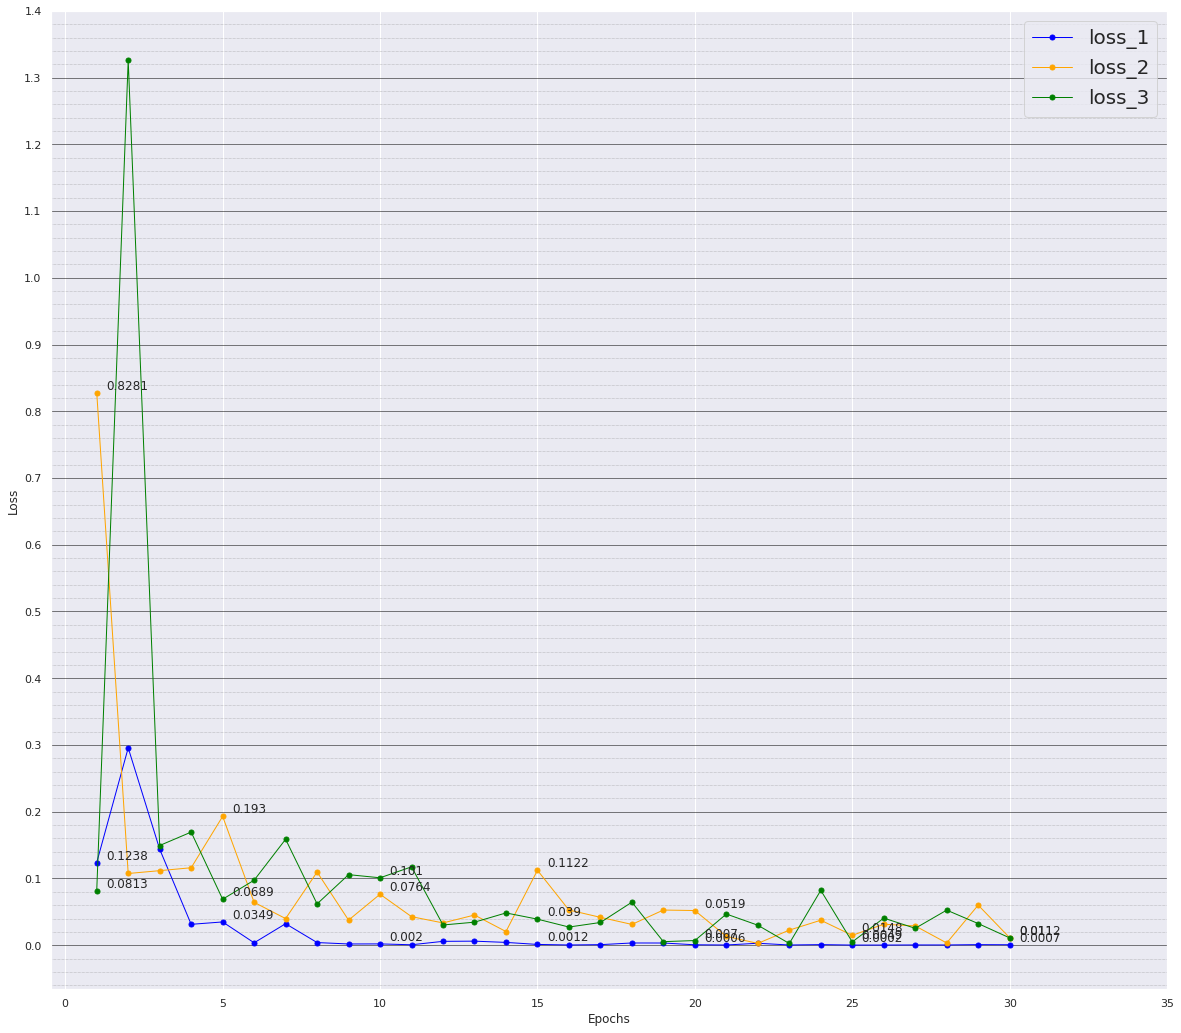

In [53]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(20,18), facecolor='white')
epochs = np.arange(1, (len(loss1_trend)+1), 1)


df=pd.DataFrame({'x': epochs, 'l1': loss1_trend, 'l2' : loss2_trend, 'l3' : loss3_trend})

marker_style = dict(linestyle='-', 
                  markersize=5)


x = np.array((np.arange(1,11)))*10

plt.plot( 'x', 'l1', data=df, marker='o', color='blue', linewidth=1, **marker_style)
plt.plot( 'x', 'l2', data=df, marker='o', color='orange', linewidth=1, **marker_style)
plt.plot( 'x', 'l3', data=df, marker='o', color='green', linewidth=1, **marker_style)


ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.minorticks_on()
plt.yticks(np.arange(0, max(loss3_trend)+.1, .1))
plt.xticks(np.arange(0, epochs[-1]+10, 5))
plt.grid(axis='y',which='major', linestyle='-', linewidth='.5', color='black') 
plt.grid(axis='y',which='minor', linestyle=':', linewidth='.5', color='grey')
matplotlib.rcParams.update({'font.size': 12})
for epoch, value in zip(epochs, loss1_trend):  # Plot also the value of the point close to it
  if epoch%5==0 or epoch==1:
    ax.annotate(str(round(value, 4)), xy=(epoch+0.3, value+0.005))
for epoch, value in zip(epochs, loss2_trend):  # Plot also the value of the point close to it
  if epoch%5==0 or epoch==1:
    ax.annotate(str(round(value, 4)), xy=(epoch+0.3, value+0.005))
for epoch, value in zip(epochs, loss3_trend):  # Plot also the value of the point close to it
  if epoch%5==0 or epoch==1:
    ax.annotate(str(round(value, 4)), xy=(epoch+0.3, value+0.005))
plt.legend(['loss_1', 'loss_2', 'loss_3'], loc='upper right', prop={'size':20})
plt.savefig('test_w.png', format='png', dpi=300)
plt.show()

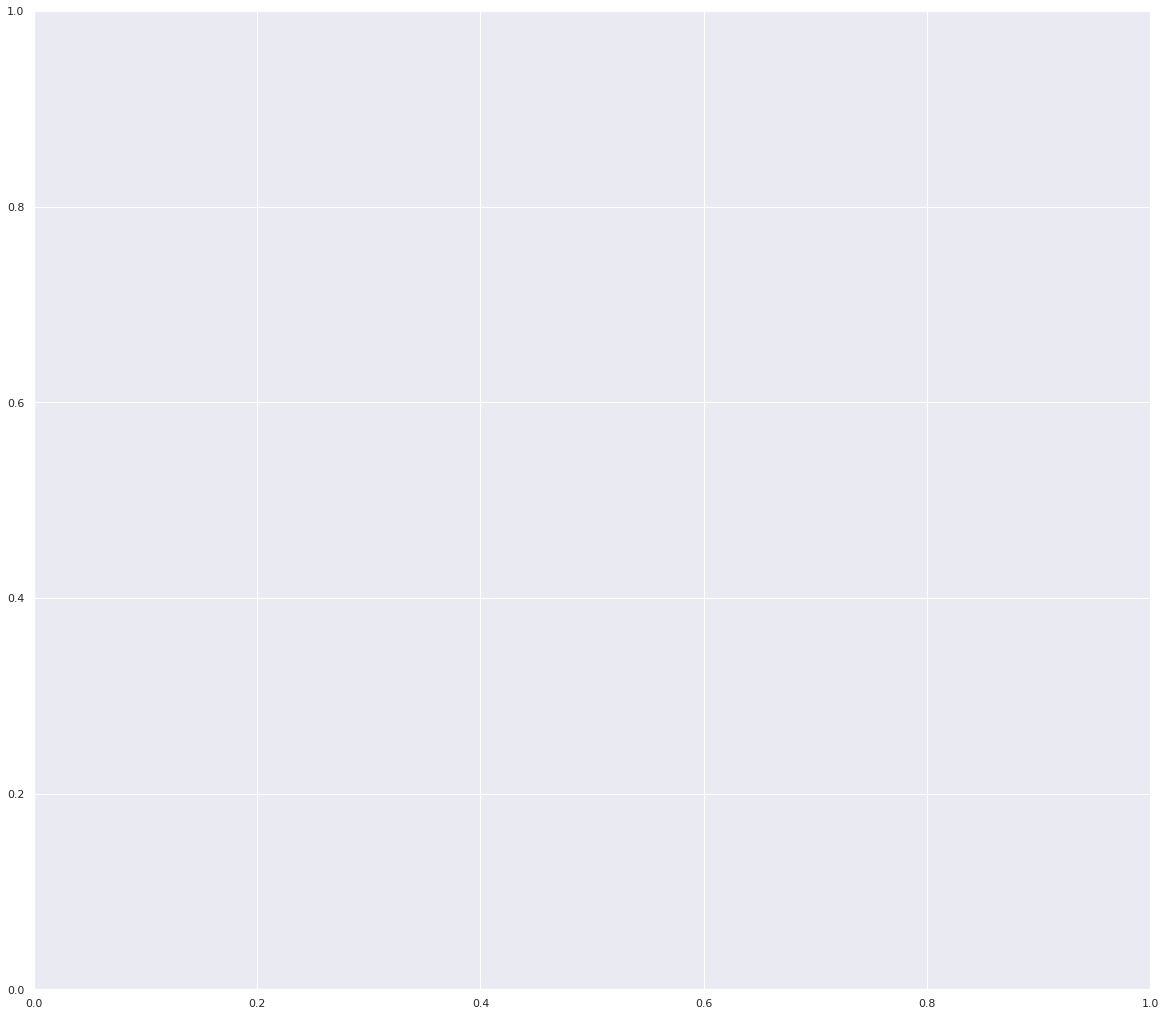

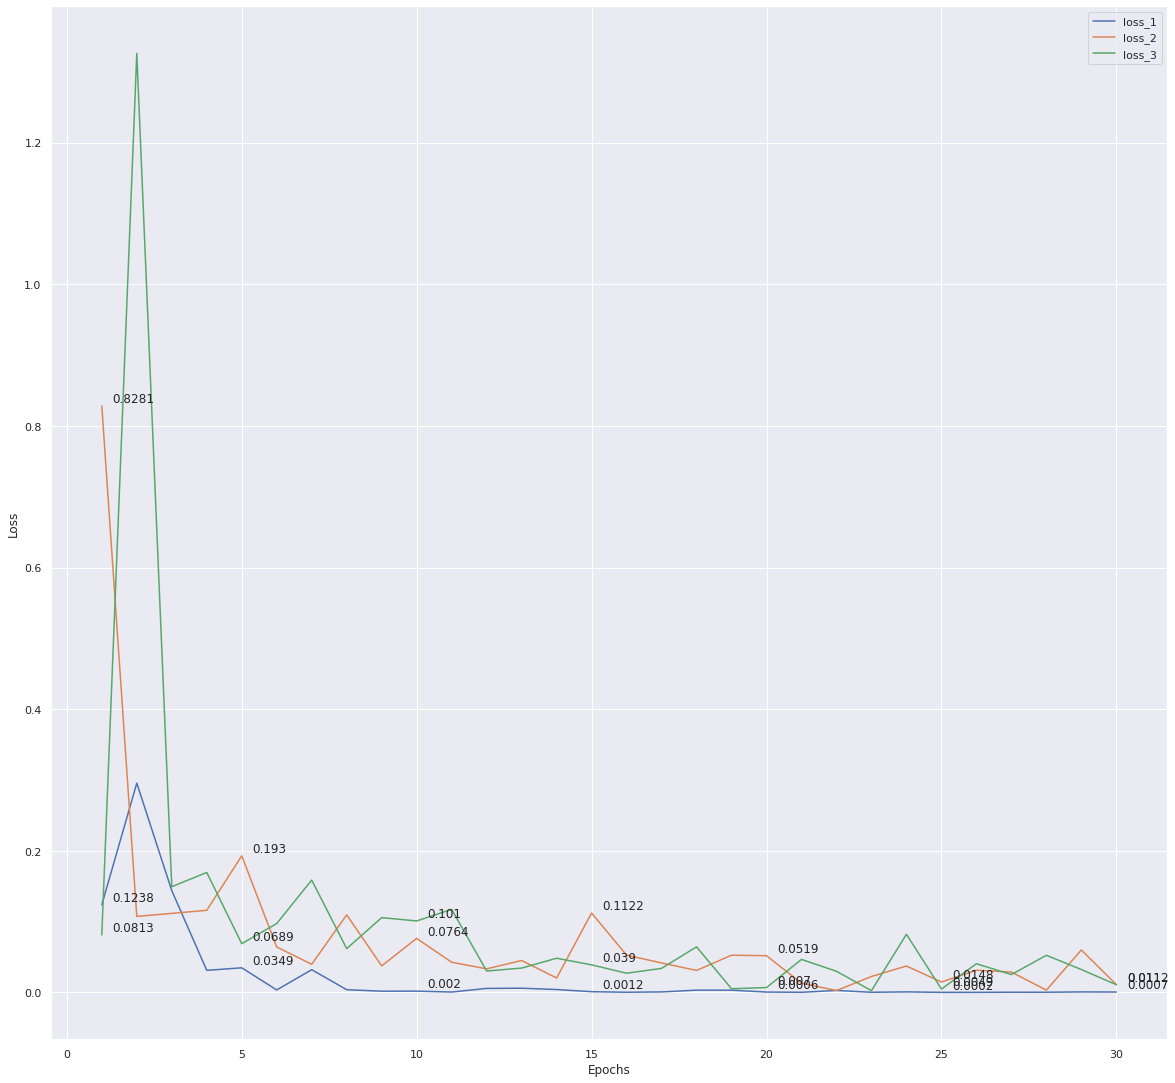

In [52]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(20,18), facecolor='white')
epochs = np.arange(1, (len(loss1_trend)+1), 1)


import seaborn as sns
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,19), facecolor='white')

datas_1 = pd.DataFrame(list(zip(epochs, loss1_trend)), columns =['epoch', 'loss'])
datas_2 = pd.DataFrame(list(zip(epochs, loss2_trend)), columns =['epoch', 'loss'])
datas_3 = pd.DataFrame(list(zip(epochs, loss3_trend)), columns =['epoch', 'loss'])
ax = sns.lineplot(x="epoch", y="loss",
                  markers=True, dashes=False, data=datas_1)
ax = sns.lineplot(x="epoch", y="loss",
                  markers=True, dashes=False, data=datas_2)
ax = sns.lineplot(x="epoch", y="loss",
                  markers=True, dashes=False, data=datas_3)

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.minorticks_on()
matplotlib.rcParams.update({'font.size': 12})
for epoch, value in zip(epochs, loss1_trend):  # Plot also the value of the point close to it
  if epoch%5==0 or epoch==1:
    ax.annotate(str(round(value, 4)), xy=(epoch+0.3, value+0.005))
for epoch, value in zip(epochs, loss2_trend):  # Plot also the value of the point close to it
  if epoch%5==0 or epoch==1:
    ax.annotate(str(round(value, 4)), xy=(epoch+0.3, value+0.005))
for epoch, value in zip(epochs, loss3_trend):  # Plot also the value of the point close to it
  if epoch%5==0 or epoch==1:
    ax.annotate(str(round(value, 4)), xy=(epoch+0.3, value+0.005))
plt.legend(['loss_1', 'loss_2', 'loss_3'], loc='upper right', prop={'size':20})
plt.savefig('test_w.png', format='png', dpi=300)
plt.gca().legend(('loss_1','loss_2','loss_3'))